In [1]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
import tensorflow as tf
import pandas as pd

In [2]:
## set gpu
gpu = 1
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu}" 
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "" 

physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


# Load model

In [3]:
fold = 6

In [4]:
model_dir = f'/media/tohn/HDD/rheology2023/EffNetB7Model/Classification/Blood_Viscosity/HN-NBL_classes/fold{fold}/R1/models/EffNetB7_thalas2classes_Class_fold{fold}_R1.h5' 
print(f"Load Model: {model_dir}")
model = load_model(model_dir, compile=False)
height = width = model.input_shape[1]
print(height, width)

Load Model: /media/tohn/HDD/rheology2023/EffNetB7Model/Classification/Blood_Viscosity/HN-NBL_classes/fold6/R1/models/EffNetB7_thalas2classes_Class_fold6_R1.h5
600 600


In [5]:
model.summary()

Model: "EffNetModel_Blood"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 300, 300, 64) 1728        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 300, 300, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 300, 300, 64) 0           stem_bn[0][0]                    
__________________________________________________________________________________

Total params: 64,102,802
Trainable params: 5,122
Non-trainable params: 64,097,680
__________________________________________________________________________________________________


## Select Data

- 6-fold Cross Validation

In [6]:
df_2dFFT = pd.read_csv("/home/kannika/code/Rheology2023/Rheology_Blood/DataBlood_Viscosity_2dFFTdataset_3channels_6Fold_split2class-ver2.csv")
train_2dFFT = df_2dFFT[df_2dFFT['fold']!=fold].reset_index(drop=True)
print("Fold Train set", set(train_2dFFT['fold']))
print(train_2dFFT.shape)

test_2dFFT = df_2dFFT[df_2dFFT['fold']==fold].reset_index(drop=True)
print("Fold Test set", set(test_2dFFT['fold']))
print(test_2dFFT.shape)

test_2dFFT.head()

Fold Train set {1, 2, 3, 4, 5}
(223, 19)
Fold Test set {6}
(45, 19)


,Unnamed: 0,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0.1.1,image_name,image_path,image_folder,folder_source,classes,Code,subclass,fold,dt,classes_binary,MCV,MCH,Hb
0,144,157.0,157.0,157.0,401.0,401.0,NBL10_D0_30HZ_20XINF_UWELL_25651129_142354_dt2...,/media/tohn/HDD/rheology2023/Blood_Viscosity_2...,NBL10_D0_30HZ_20XINF_UWELL_25651129_142354,SSD_Backup,NBL,NBL10,Normal,6,"[2, 5, 7]",0.0,83.5,25.8,13.0
1,145,164.0,164.0,164.0,396.0,396.0,NBL10_D0_30HZ_20XINF_UWELL_25651129_141005_dt2...,/media/tohn/HDD/rheology2023/Blood_Viscosity_2...,NBL10_D0_30HZ_20XINF_UWELL_25651129_141005,SSD_Backup,NBL,NBL10,Normal,6,"[2, 5, 7]",0.0,83.5,25.8,13.0
2,146,167.0,167.0,167.0,399.0,399.0,NBL10_D0_30HZ_20XINF_UWELL_25651129_141915_dt2...,/media/tohn/HDD/rheology2023/Blood_Viscosity_2...,NBL10_D0_30HZ_20XINF_UWELL_25651129_141915,SSD_Backup,NBL,NBL10,Normal,6,"[2, 5, 7]",0.0,83.5,25.8,13.0
3,147,168.0,168.0,168.0,403.0,403.0,NBL10_D0_30HZ_20XINF_UWELL_25651129_142839_dt2...,/media/tohn/HDD/rheology2023/Blood_Viscosity_2...,NBL10_D0_30HZ_20XINF_UWELL_25651129_142839,SSD_Backup,NBL,NBL10,Normal,6,"[2, 5, 7]",0.0,83.5,25.8,13.0
4,148,172.0,172.0,172.0,398.0,398.0,NBL10_D0_30HZ_20XINF_UWELL_25651129_141653_dt2...,/media/tohn/HDD/rheology2023/Blood_Viscosity_2...,NBL10_D0_30HZ_20XINF_UWELL_25651129_141653,SSD_Backup,NBL,NBL10,Normal,6,"[2, 5, 7]",0.0,83.5,25.8,13.0


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (height, width)
BATCH_SIZE = 16

### Get data Loder
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range=20,
                    brightness_range=[0.5, 1.5],
                    shear_range=0.5,
                    horizontal_flip = False,
                    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_2dFFT,
        directory = None,
        x_col = 'image_path',
        y_col = 'classes',
        target_size = (height, width),
        batch_size=BATCH_SIZE,
        color_mode= 'rgb',
        class_mode='categorical')


#label
labels = (train_generator.class_indices)
labels = dict((v,k.replace("C","")) for k,v in labels.items())
print(labels)

Found 223 validated image filenames belonging to 2 classes.
{0: 'HN', 1: 'NBL'}


## Prediction

In [8]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    
    return result[0]

In [9]:
#Predict
pred_list = list()
prob_list = list()
img_path=test_2dFFT['image_path'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])

In [10]:
predict

array([0.8158263 , 0.18417373], dtype=float32)

In [11]:
print(len(pred_list))
print(len(prob_list))

test_2dFFT['category'] = pred_list
test_2dFFT['Prob'] = prob_list
test_2dFFT.head()

45
45


,Unnamed: 0,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0.1.1,image_name,image_path,image_folder,folder_source,...,Code,subclass,fold,dt,classes_binary,MCV,MCH,Hb,category,Prob
0,144,157.0,157.0,157.0,401.0,401.0,NBL10_D0_30HZ_20XINF_UWELL_25651129_142354_dt2...,/media/tohn/HDD/rheology2023/Blood_Viscosity_2...,NBL10_D0_30HZ_20XINF_UWELL_25651129_142354,SSD_Backup,...,NBL10,Normal,6,"[2, 5, 7]",0.0,83.5,25.8,13.0,HN,0.713382
1,145,164.0,164.0,164.0,396.0,396.0,NBL10_D0_30HZ_20XINF_UWELL_25651129_141005_dt2...,/media/tohn/HDD/rheology2023/Blood_Viscosity_2...,NBL10_D0_30HZ_20XINF_UWELL_25651129_141005,SSD_Backup,...,NBL10,Normal,6,"[2, 5, 7]",0.0,83.5,25.8,13.0,HN,0.656729
2,146,167.0,167.0,167.0,399.0,399.0,NBL10_D0_30HZ_20XINF_UWELL_25651129_141915_dt2...,/media/tohn/HDD/rheology2023/Blood_Viscosity_2...,NBL10_D0_30HZ_20XINF_UWELL_25651129_141915,SSD_Backup,...,NBL10,Normal,6,"[2, 5, 7]",0.0,83.5,25.8,13.0,HN,0.679387
3,147,168.0,168.0,168.0,403.0,403.0,NBL10_D0_30HZ_20XINF_UWELL_25651129_142839_dt2...,/media/tohn/HDD/rheology2023/Blood_Viscosity_2...,NBL10_D0_30HZ_20XINF_UWELL_25651129_142839,SSD_Backup,...,NBL10,Normal,6,"[2, 5, 7]",0.0,83.5,25.8,13.0,HN,0.715569
4,148,172.0,172.0,172.0,398.0,398.0,NBL10_D0_30HZ_20XINF_UWELL_25651129_141653_dt2...,/media/tohn/HDD/rheology2023/Blood_Viscosity_2...,NBL10_D0_30HZ_20XINF_UWELL_25651129_141653,SSD_Backup,...,NBL10,Normal,6,"[2, 5, 7]",0.0,83.5,25.8,13.0,HN,0.667628


In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix

act = test_2dFFT['classes'].array
pred = test_2dFFT['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 55.55555555555556%
              precision    recall  f1-score   support

          HN       0.55      1.00      0.71        24
         NBL       1.00      0.05      0.09        21

    accuracy                           0.56        45
   macro avg       0.77      0.52      0.40        45
weighted avg       0.76      0.56      0.42        45



### Confusion matrix

Text(0.5, 21.5, 'Predicted label')

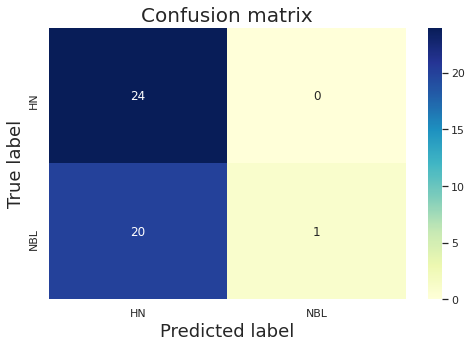

In [13]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## Confusion matrix

In [14]:
cm

array([[24,  0],
       [20,  1]])

In [15]:
tn, fp, fn, tp = confusion_matrix(act, pred).ravel()
print("True Negative (TN):", tn)
print("False Positive (FP):", fp)
print("False Negative (FN):", fn)
print("True Positive (TP):", tp)

True Negative (TN): 24
False Positive (FP): 0
False Negative (FN): 20
True Positive (TP): 1
